# 1. Environment set up
This section ensures all libraries and dataset are correctly imported.

If data is already mounted select:
              `import_data = False`

In [0]:
import_data = True

### Optional GPU check

In [4]:
# Taken from
# https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# Colab only provides one GPU and it is not always guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
  printm()

  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


### Cloning the repository and downloading the data

In [5]:
if import_data == False:
  # Change directory
  %cd /content/keras_triplet_descriptor
else:
  # Clone repo
  !git clone https://github.com/MatchLab-Imperial/keras_triplet_descriptor
  %cd /content/keras_triplet_descriptor
  # Download data
  !wget -O hpatches_data.zip https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
  # Extract data
  !unzip -q ./hpatches_data.zip
  !rm ./hpatches_data.zip


Cloning into 'keras_triplet_descriptor'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 181 (delta 0), reused 1 (delta 0), pack-reused 178
Receiving objects: 100% (181/181), 149.87 MiB | 21.75 MiB/s, done.
Resolving deltas: 100% (65/65), done.
Checking out files: 100% (69/69), done.
/content/keras_triplet_descriptor
--2019-03-21 05:59:49--  https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Resolving imperialcollegelondon.box.com (imperialcollegelondon.box.com)... 107.152.26.197
Connecting to imperialcollegelondon.box.com (imperialcollegelondon.box.com)|107.152.26.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip [following]
--2019-03-21 05:59:49--  https://imperialcollegelondon.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Reusing existing con

### Importing Necessary Modules

In [6]:
!pip install -U seaborn

import sys
import json
import os
import glob
import time
import tensorflow as tf
import numpy as np
import cv2
import random

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization 
from keras.layers import Input, UpSampling2D, concatenate  

from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet

# Plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams["patch.force_edgecolor"] = True

# To download files
from google.colab import files

from sklearn.decomposition import PCA
import pandas as pd

    100% |████████████████████████████████| 204kB 24.6MB/s 
  Stored in directory: /root/.cache/pip/wheels/fc/1c/74/c8f80a532c06a789599b8659b117ec7d7574cac4a06f7dabfe
Successfully built seaborn
fastai 0.7.0 has requirement torch<0.4, but you'll have torch 1.0.1.post2 which is incompatible.
  Found existing installation: seaborn 0.7.1
    Uninstalling seaborn-0.7.1:
      Successfully uninstalled seaborn-0.7.1


Using TensorFlow backend.


In [0]:
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

hpatches_dir = './hpatches'
splits_path = './splits.json'

splits_json = json.load(open(splits_path, 'rb'))
split = splits_json['a']

train_fnames = split['train']
test_fnames = split['test']

seqs = glob.glob(hpatches_dir+'/*')
seqs = [os.path.abspath(p) for p in seqs]   
seqs_train = list(filter(lambda x: x.split('/')[-1] in train_fnames, seqs)) 
seqs_test = list(filter(lambda x: x.split('/')[-1] in split['test'], seqs)) 


# Denoiser

In [0]:
def get_denoise_model(shape):
    
  inputs = Input(shape)
  
  ## Encoder starts
  conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  
  ## Bottleneck
  conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)

  ## Now the decoder starts
  up3 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv2))
  merge3 = concatenate([conv1,up3], axis = -1)
  conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge3)
    
  conv4 = Conv2D(1, 3,  padding = 'same')(conv3)

  shallow_net = Model(inputs = inputs, outputs = conv4)
  
  return shallow_net


In [0]:
# To use a small amount of data
denoise_generator = DenoiseHPatches(random.sample(seqs_train, 3), batch_size=50)
denoise_generator_val = DenoiseHPatches(random.sample(seqs_test, 1), batch_size=50)

100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


In [0]:
# To use all the data
denoise_generator = DenoiseHPatches(seqs_train, batch_size=50)
denoise_generator_val = DenoiseHPatches(seqs_test, batch_size=50)

In [0]:
shape = (32, 32, 1)
denoise_model = get_denoise_model(shape)

In [0]:
# Random seeds
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

# Compile model
denoise_model_adam = get_denoise_model( (32, 32, 1) )
denoise_model_adam.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae','mse','accuracy'])

# Train model with adam
denoise_history_adam = denoise_model_adam.fit_generator(generator=denoise_generator,
                                              epochs=1,
                                              verbose=1,
                                              validation_data=denoise_generator_val)

Epoch 1/1
1457/1457 [==============================] - 40s 28ms/step - loss: 7.0901 - mean_absolute_error: 7.0901 - mean_squared_error: 164.4622 - acc: 0.0585 - val_loss: 6.3271 - val_mean_absolute_error: 6.3271 - val_mean_squared_error: 77.0257 - val_acc: 0.0637


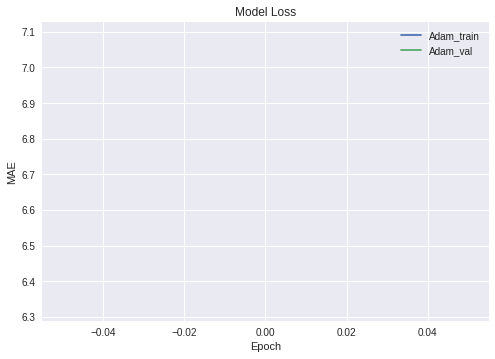

In [0]:
# Mean absolute error
plt.plot(denoise_history_adam.history['loss'])
plt.plot(denoise_history_adam.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Adam_train','Adam_val'])

100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


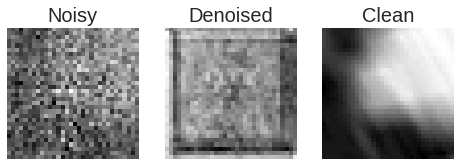

In [0]:
plot_denoise(denoise_model)

In [0]:
denoise_model.summary()

# Deep U-Net

In [0]:
from keras.layers import Input, UpSampling2D, concatenate,BatchNormalization 
from keras.models import Model


def get_denoise_deep_model(shape):
  
  inputs = Input(shape)
  
  #bn1 = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001)(inputs)
  
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  drop5 = Dropout(0.5)(conv5)

  ## Now the decoder starts

  up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)

  up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)

  up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)

  up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv10 = Conv2D(1, 3,  padding = 'same')(conv9)

  deep_net = Model(inputs = inputs, outputs = conv10)
  
  return deep_net

In [0]:
# Random seeds
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

# Compile model
denoise_model_deep = get_denoise_deep_model( (32, 32, 1) )
denoise_model_deep.compile(loss='mean_absolute_error', optimizer='adam')

# Train model with adam
denoise_history_deep = denoise_model_deep.fit_generator(generator=denoise_generator,
                                              epochs=1,
                                              verbose=1,
                                              validation_data=denoise_generator_val)

Epoch 1/1
1457/1457 [==============================] - 233s 160ms/step - loss: 14.4926 - val_loss: 5.9086


In [0]:
denoise_history_deep = denoise_model_deep.fit_generator(generator=denoise_generator,
                                              epochs=1,
                                              verbose=1,
                                              validation_data=denoise_generator_val)

Epoch 1/1
1457/1457 [==============================] - 230s 158ms/step - loss: 5.2007 - val_loss: 5.7546


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


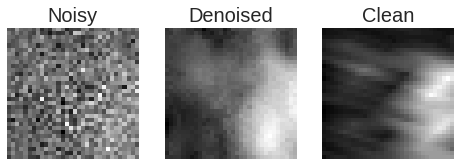

In [0]:
plot_denoise(denoise_model_deep)

# Deep DnCNN

In [0]:
from keras.layers import  Input,Conv2D,BatchNormalization,Activation,Subtract
from keras.models import Model, load_model

def DnCNN(depth,filters=64):
  
  # Input definition
  layer_count = 0
  inpt = Input((32,32,1), name = 'input'+str(layer_count))
  
  
  # 1st layer, Conv+relu
  layer_count += 1
  x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),kernel_initializer='Orthogonal', padding='same',name = 'conv'+str(layer_count))(inpt)
  layer_count += 1
  x = Activation('relu',name = 'relu'+str(layer_count))(x)
  
  # depth-2 layers, Conv+BN+relu
  for i in range(depth-2):
    layer_count += 1
    x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),kernel_initializer='Orthogonal', padding='same',use_bias = False,name = 'conv'+str(layer_count))(x)
    layer_count += 1
    x = Activation('relu',name = 'relu'+str(layer_count))(x)   
    layer_count += 1
    x = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001, name = 'bn'+str(layer_count))(x)
      
  # last layer, Conv
  layer_count += 1
  x = Conv2D(filters=1, kernel_size=(3,3), strides=(1,1), kernel_initializer='Orthogonal',padding='same',use_bias = False,name = 'conv'+str(layer_count))(x)
  layer_count += 1
  x = Subtract(name = 'subtract' + str(layer_count))([inpt, x])   # input - noise
  model = Model(inputs=inpt, outputs=x)

  return model  
    

In [0]:
# Random seeds
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

# To use a small amount of data
denoise_generator = DenoiseHPatches(random.sample(seqs_train, 2), batch_size=100)
denoise_generator_val = DenoiseHPatches(random.sample(seqs_test, 1), batch_size=100)

100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


In [0]:
# Random seeds
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)



# Compile model
model = DnCNN(depth=13,filters=64)
model.compile(optimizer='Adam', loss='mean_absolute_error')

# Train model with adam
denoise_hist_bn = model.fit_generator(generator=denoise_generator,
                                              epochs=1,
                                              verbose=1,
                                              validation_data=denoise_generator_val)




Epoch 1/1
463/463 [==============================] - 108s 233ms/step - loss: 6.4449 - val_loss: 4.8633


In [0]:
denoise_hist_bn = model.fit_generator(generator=denoise_generator,
                                              epochs=1,
                                              verbose=1,
                                              validation_data=denoise_generator_val)


Epoch 1/1
1186/1186 [==============================] - 216s 182ms/step - loss: 4.7955 - val_loss: 5.1204


In [0]:
adm = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.9, amsgrad=False)

In [0]:
model.compile(optimizer=adm, loss='mean_absolute_error')
denoise_hist_bn = model.fit_generator(generator=denoise_generator,
                                              epochs=1,
                                              verbose=1,
                                              validation_data=denoise_generator_val)

Epoch 1/1
1186/1186 [==============================] - 225s 190ms/step - loss: 4.7081 - val_loss: 5.0836


In [0]:
print(model.summary())


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


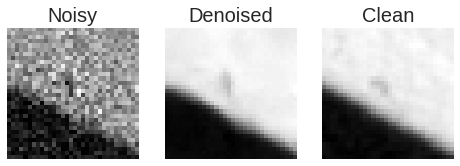

In [0]:
plot_denoise(model)

# Deep DnCNN Denoiser model generation and full training

In [0]:
# Random seeds
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)


# To use a small amount of data
denoise_generator = DenoiseHPatches(random.sample(seqs_train, 3), batch_size=50)
denoise_generator_val = DenoiseHPatches(random.sample(seqs_test, 1), batch_size=50)


# To use all the data
full_denoise_generator = DenoiseHPatches(seqs_train, batch_size=50)
full_denoise_generator_val = DenoiseHPatches(seqs_test, batch_size=50)

100%|██████████| 40/40 [00:44<00:00,  1.09s/it]


In [0]:
# Random seeds
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

# Compile model
DnCNNmodel = DnCNN(depth=17,filters=64)
DnCNNmodel.compile(optimizer='Adam', loss='mean_absolute_error')

# Train model with adam
denoise_hist_bn = DnCNNmodel.fit_generator(generator=denoise_generator,
                                              epochs=1,
                                              verbose=1,
                                              validation_data=denoise_generator_val)


In [0]:
plt.plot(denoise_history_adam.history['loss'])
plt.plot(denoise_history_adam.history['val_loss'])

In [0]:
from google.colab import files

# Random seeds
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

# Compile model
DnCNNmodel = DnCNN(depth=17,filters=64)
DnCNNmodel.compile(optimizer='Adam', loss='mean_absolute_error')

hist_trn_loss = []
hist_val_loss = []
for e in range(10):
  denoise_history_DM = DnCNNmodel.fit_generator(generator = denoise_generator, 
                                           epochs=1, verbose=1, 
                                           validation_data=denoise_generator_val)
  
  hist_trn_loss.append(denoise_history_DM.history['loss'])
  hist_val_loss.append(denoise_history_DM.history['val_loss'])
  
  print(hist_trn_loss)
  print(hist_val_loss)
  
  ### Saves optimizer and weights
  DnCNNmodel.save('denoise.h5') 
  ### Uploads files to external hosting
  !curl -F "file=@denoise.h5" https://file.io

Epoch 1/1
1116/1116 [==============================] - 227s 204ms/step - loss: 6.0404 - val_loss: 5.3835
[[6.040407796914432]]
[[5.383535405438781]]
{"success":true,"key":"E9vVjV","link":"https://file.io/E9vVjV","expiry":"14 days"}Epoch 1/1
1116/1116 [==============================] - 213s 190ms/step - loss: 5.3192 - val_loss: 4.8376
[[6.040407796914432], [5.319197417160089]]
[[5.383535405438781], [4.83761812196545]]
{"success":true,"key":"knr4ak","link":"https://file.io/knr4ak","expiry":"14 days"}Epoch 1/1
1116/1116 [==============================] - 212s 190ms/step - loss: 5.2103 - val_loss: 4.7791
[[6.040407796914432], [5.319197417160089], [5.210347558435146]]
[[5.383535405438781], [4.83761812196545], [4.779098496828169]]
{"success":true,"key":"qONk9B","link":"https://file.io/qONk9B","expiry":"14 days"}Epoch 1/1
1116/1116 [==============================] - 212s 190ms/step - loss: 5.1528 - val_loss: 4.7060
[[6.040407796914432], [5.319197417160089], [5.210347558435146], [5.15279220552

In [0]:
# One run through the entire dataset
denoise_history_DM = DnCNNmodel.fit_generator(generator = full_denoise_generator, 
                                           epochs=1, verbose=1, 
                                           validation_data=full_denoise_generator_val)
  
hist_trn_loss.append(denoise_history_DM.history['loss'])
hist_val_loss.append(denoise_history_DM.history['val_loss'])

print(hist_trn_loss)
print(hist_val_loss)

### Saves optimizer and weights
DnCNNmodel.save('denoise.h5') 
### Uploads files to external hosting
!curl -F "file=@denoise.h5" https://file.io

Epoch 1/1
31179/31179 [==============================] - 5978s 192ms/step - loss: 4.7587 - val_loss: 4.6895
[[6.040407796914432], [5.319197417160089], [5.210347558435146], [5.152792205520001], [5.115022057700755], [5.075328221885107], [5.054336958888611], [5.034461012450597], [5.020696533623562], [4.9990695774768845], [4.758705291973167]]
[[5.383535405438781], [4.83761812196545], [4.779098496828169], [4.706028846160095], [5.176277971418122], [4.761962252460443], [4.66615708280437], [4.639835457320469], [5.05572408155688], [4.627405095551668], [4.689495579414167]]
{"success":true,"key":"uuVACf","link":"https://file.io/uuVACf","expiry":"14 days"}

In [0]:
# Try to overfit smaller batch to gain better initialisation
# Freeze all the layers
for layer in DnCNNmodel.layers[:-3]:
    layer.trainable = False
    
for layer in DnCNNmodel.layers[-3:-1]:
    layer.trainable = True
    
#DnCNNmodel.trainable = True
DnCNNmodel.compile(optimizer='Adam', loss='mean_absolute_error')    

In [0]:
print(DnCNNmodel.summary())

In [0]:
# Fine tune first layers with all data

adm = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
DnCNNmodel.compile(optimizer=adm, loss='mean_absolute_error')    

for e in range(1):
  denoise_history_DM = DnCNNmodel.fit_generator(generator = full_denoise_generator, 
                                           epochs=1, verbose=1, 
                                           validation_data=full_denoise_generator_val)
  
  hist_trn_loss.append(denoise_history_DM.history['loss'])
  hist_val_loss.append(denoise_history_DM.history['val_loss'])
  
  print(hist_trn_loss)
  print(hist_val_loss)



In [0]:
### Saves optimizer and weights
DnCNNmodel.save('denoise_dcnn_full12b.h5') 
### Uploads files to external hosting
!curl -F "file=@denoise_dcnn_full12b.h5" https://file.io

In [0]:
# Emergency restore of DcNN weights from 10small + 1full train
DnCNNmodel = keras.models.load_model('./denoise_dcnn_full11b.h5')

# Shallow DnCNN generation and training

### Restore model util

In [5]:
# Just uncomment if needed
DnCNNmodel = keras.models.load_model('./shallow_DcNN_hitrain_8e.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


### Generators

In [11]:
# Random seeds
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)


# To use a small amount of data
denoise_generator = DenoiseHPatches(random.sample(seqs_train, 40), batch_size=50)

# To use all the data
#full_denoise_generator = DenoiseHPatches(seqs_train, batch_size=50)
full_denoise_generator_val = DenoiseHPatches(seqs_test, batch_size=50)

100%|██████████| 40/40 [00:48<00:00,  1.48s/it]


### Model definition

In [0]:
from keras.layers import  Input,Conv2D,BatchNormalization,Activation,Subtract
from keras.models import Model, load_model

def DnCNN(shape):
  
  depth = 6
  filters = 64
  # Input definition
  layer_count = 0
  inpt = Input(shape, name = 'input'+str(layer_count))
  
  
  # 1st layer, Conv+relu
  layer_count += 1
  x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),kernel_initializer='Orthogonal', padding='same',name = 'conv'+str(layer_count))(inpt)
  layer_count += 1
  x = Activation('relu',name = 'relu'+str(layer_count))(x)
  
  # depth-2 layers, Conv+BN+relu
  for i in range(depth-2):
    layer_count += 1
    x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),kernel_initializer='Orthogonal', padding='same',use_bias = False,name = 'conv'+str(layer_count))(x)
    layer_count += 1
    x = Activation('relu',name = 'relu'+str(layer_count))(x)   
    layer_count += 1
    x = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001, name = 'bn'+str(layer_count))(x)
      
  # last layer, Conv
  layer_count += 1
  x = Conv2D(filters=1, kernel_size=(3,3), strides=(1,1), kernel_initializer='Orthogonal',padding='same',use_bias = False,name = 'conv'+str(layer_count))(x)
  layer_count += 1
  x = Subtract(name = 'subtract' + str(layer_count))([inpt, x])   # input - noise
  model = Model(inputs=inpt, outputs=x)

  return model  

### Training

In [13]:
# Random seeds
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

shape = (32,32,1)
# Compile model
DnCNNmodel = DnCNN(shape)
DnCNNmodel.compile(optimizer='Adam', loss='mean_absolute_error')

# Initialise lists to record training history
dcnn_loss = []
dcnn_val = []
dcnn_epo = []
dcnn_count = 1

# Train model with adam
denoise_hist_bn = DnCNNmodel.fit_generator(generator=denoise_generator,
                                              epochs=1,
                                              verbose=1,
                                              validation_data=full_denoise_generator_val)

dcnn_epo.append(dcnn_count)
dcnn_loss.append(denoise_hist_bn.history['loss'])
dcnn_val.append(denoise_hist_bn.history['val_loss'])
dcnn_count += 1

# Save model
DnCNNmodel.save('shallow_DcNN_hitrain_5e.h5')
!curl -F "file=@shallow_DcNN_hitrain_5e.h5" https://file.io

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
14992/14992 [==============================] - 1040s 69ms/step - loss: 5.2142 - val_loss: 5.0256


In [18]:
# Generate new random training subsets for each training epoch
# to increase generalisation

for e in range(4):
  print('Epoch number',dcnn_epo[-1])
  # Random seeds
  random.seed(e)

  # To use a small amount of data
  denoise_generator = DenoiseHPatches(random.sample(seqs_train, 40), batch_size=50)
  
  # Train model with adam
  denoise_hist_bn = DnCNNmodel.fit_generator(generator=denoise_generator,
                                                epochs=1,
                                                verbose=1,
                                                validation_data=full_denoise_generator_val)

  dcnn_epo.append(dcnn_count)
  dcnn_loss.append(denoise_hist_bn.history['loss'])
  dcnn_val.append(denoise_hist_bn.history['val_loss'])
  dcnn_count += 1


# Print loss curves
print('Epochs',dcnn_epo)
print('Loss', dcnn_loss)
print('Val',dcnn_val)  

# Save model
DnCNNmodel.save('shallow_DcNN_hitrain_5e.h5')
!curl -F "file=@shallow_DcNN_hitrain_5e.h5" https://file.io
  

  0%|          | 0/40 [00:00<?, ?it/s]

('Epoch number', [1])


100%|██████████| 40/40 [00:38<00:00,  1.20s/it]


Epoch 1/1
14289/14289 [==============================] - 995s 70ms/step - loss: 4.9439 - val_loss: 5.0099


  0%|          | 0/40 [00:00<?, ?it/s]

('Epoch number', [1, 2])


100%|██████████| 40/40 [00:40<00:00,  1.15it/s]


Epoch 1/1
15744/15744 [==============================] - 1055s 67ms/step - loss: 4.9005 - val_loss: 4.9227


  0%|          | 0/40 [00:00<?, ?it/s]

('Epoch number', [1, 2, 3])


100%|██████████| 40/40 [00:41<00:00,  1.20s/it]


Epoch 1/1
15947/15947 [==============================] - 1084s 68ms/step - loss: 4.7152 - val_loss: 4.9136


  0%|          | 0/40 [00:00<?, ?it/s]

('Epoch number', [1, 2, 3, 4])


100%|██████████| 40/40 [00:43<00:00,  1.35s/it]


Epoch 1/1
17005/17005 [==============================] - 1136s 67ms/step - loss: 4.8064 - val_loss: 4.9376
('Epochs', [1, 2, 3, 4, 5])
('Loss', [[5.2142469500019555], [4.94385597371965], [4.900529913013664], [4.715167493919463], [4.806397549063624]])
('Val', [[5.025616133394517], [5.009902938632514], [4.922744863502623], [4.913619204581253], [4.937603932177927]])
{"success":true,"key":"CeZKFl","link":"https://file.io/CeZKFl","expiry":"14 days"}

(4, 6)

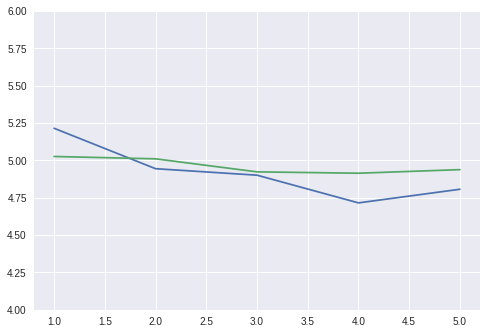

In [23]:
plt.plot(dcnn_epo,dcnn_loss)
plt.plot(dcnn_epo,dcnn_val)
plt.ylim([4,6])



As the network starts overfitting, we apply further regularisation to the training data.
Instead of reducing the learning rate, we increase batch size within the randomly sampled generators.

In [24]:
# Generate new random training subsets for each training epoch
# to increase generalisation

for e in range(2):
  print('Epoch number',dcnn_epo[-1])
  # Random seeds
  random.seed(e)

  # To use a small amount of data
  denoise_generator = DenoiseHPatches(random.sample(seqs_train, 40), batch_size=100)
  
  # Train model with adam
  denoise_hist_bn = DnCNNmodel.fit_generator(generator=denoise_generator,
                                                epochs=1,
                                                verbose=1,
                                                validation_data=full_denoise_generator_val)

  dcnn_epo.append(dcnn_count)
  dcnn_loss.append(denoise_hist_bn.history['loss'])
  dcnn_val.append(denoise_hist_bn.history['val_loss'])
  dcnn_count += 1


# Print loss curves
print('Epochs',dcnn_epo)
print('Loss', dcnn_loss)
print('Val',dcnn_val)  

# Save model
DnCNNmodel.save('shallow_DcNN_hitrain_7e.h5')
!curl -F "file=@shallow_DcNN_hitrain_7e.h5" https://file.io
  

  0%|          | 0/40 [00:00<?, ?it/s]

('Epoch number', 5)


100%|██████████| 40/40 [00:37<00:00,  1.21s/it]


Epoch 1/1
7144/7144 [==============================] - 839s 117ms/step - loss: 4.8279 - val_loss: 4.8887


  0%|          | 0/40 [00:00<?, ?it/s]

('Epoch number', 6)


100%|██████████| 40/40 [00:40<00:00,  1.16it/s]


Epoch 1/1
7872/7872 [==============================] - 894s 114ms/step - loss: 4.8093 - val_loss: 4.8817
('Epochs', [1, 2, 3, 4, 5, 6, 7])
('Loss', [[5.2142469500019555], [4.94385597371965], [4.900529913013664], [4.715167493919463], [4.806397549063624], [4.827891404257643], [4.809257615569646]])
('Val', [[5.025616133394517], [5.009902938632514], [4.922744863502623], [4.913619204581253], [4.937603932177927], [4.888653039419119], [4.8816780390201275]])
{"success":true,"key":"cjbxUl","link":"https://file.io/cjbxUl","expiry":"14 days"}

(4, 6)

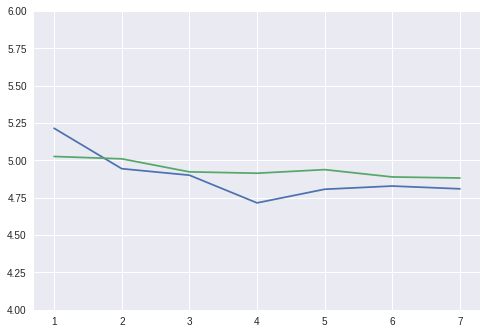

In [9]:
dcnn_epo = [1, 2, 3, 4, 5, 6, 7]
dcnn_loss = [[5.2142469500019555], [4.94385597371965], [4.900529913013664], [4.715167493919463], [4.806397549063624], [4.827891404257643], [4.809257615569646]]
dcnn_val = [[5.025616133394517], [5.009902938632514], [4.922744863502623], [4.913619204581253], [4.937603932177927], [4.888653039419119], [4.8816780390201275]]

plt.plot(dcnn_epo,dcnn_loss)
plt.plot(dcnn_epo,dcnn_val)
plt.ylim([4,6])

As we can see, the network generalises very well.

Now, we can train on the entire train dataset all at once, so to converge on the real training error reducing the risk of overfitting.
To improve computational time, we increase again batch size. To allow so, we need to free the RAM removing the validation generator. The Validation loss will be calculated after evaluating the model.

In [6]:
# To use a small amount of data
denoise_generator = DenoiseHPatches(seqs_train, batch_size=150)

100%|██████████| 76/76 [01:13<00:00,  1.10s/it]


In [10]:
# Train model with adam
denoise_hist_bn = DnCNNmodel.fit_generator(generator=denoise_generator,
                                              epochs=1,
                                              verbose=1)

dcnn_epo.append(dcnn_count)
dcnn_loss.append(denoise_hist_bn.history['loss'])
#dcnn_val.append(denoise_hist_bn.history['val_loss'])
dcnn_count += 1


# Print loss curves
print('Epochs',dcnn_epo)
print('Loss', dcnn_loss)
#print('Val',dcnn_val)  

# Save model
DnCNNmodel.save('shallow_DcNN_hitrain_9e.h5')
!curl -F "file=@shallow_DcNN_hitrain_9e.h5" https://file.io
  

Epoch 1/1
10393/10393 [==============================] - 1132s 109ms/step - loss: 4.8664
('Epochs', [1, 2, 3, 4, 5, 6, 7, 8, 9])
('Loss', [[5.2142469500019555], [4.94385597371965], [4.900529913013664], [4.715167493919463], [4.806397549063624], [4.827891404257643], [4.809257615569646], [4.871348178984283], [4.866369459496693]])
{"success":true,"key":"K2ZfIQ","link":"https://file.io/K2ZfIQ","expiry":"14 days"}

To calculate the validation loss, we have to regenerate the validation generator.
First, we delete the training generator to make RAM space.

In [11]:
dcnn_epo = [1, 2, 3, 4, 5, 6, 7,8,9]
dcnn_loss = [[5.2142469500019555], [4.94385597371965], [4.900529913013664], [4.715167493919463], [4.806397549063624], [4.827891404257643], [4.809257615569646], [4.871348178984283], [4.866369459496693]]
dcnn_val = [[5.025616133394517], [5.009902938632514], [4.922744863502623], [4.913619204581253], [4.937603932177927], [4.888653039419119], [4.8816780390201275],[0],[0]]

plt.plot(dcnn_epo,dcnn_loss)
plt.plot(dcnn_epo,dcnn_val)
plt.ylim([4,6])

(4, 6)

In [0]:
dcnn_count = 9

In [0]:
dcnn_epo = [1, 2, 3, 4, 5, 6, 7, 8]

In [0]:
dcnn_loss = [[5.2142469500019555], [4.94385597371965], [4.900529913013664], [4.715167493919463], [4.806397549063624], [4.827891404257643], [4.809257615569646], [4.871348178984283]]

In [0]:
del denoise_generator

In [12]:
# Random seeds
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

# To use all the data
full_denoise_generator_val = DenoiseHPatches(seqs_test, batch_size=150)

100%|██████████| 40/40 [00:45<00:00,  1.36s/it]


In [0]:
del denoise_generator

# Cascaded shallow DnCNN
As we manage to quickly train an already powerful denoiser that generalises well, we can cascade it and train it keeping the first DnCNN frozen.
This is comparable to training the same DnCNN on less noisy data.

## Define cascaded model

In [12]:
# Import trained shallow DnCNN
first_DnCNN = keras.models.load_model('./shallow_DcNN_hitrain_9e.h5')
first_DnCNN.name = 'first_DnCNN'
# Freeze first network
first_DnCNN.trainable = False
for lr in first_DnCNN.layers:
  lr.name = '1st_DcNN_'+lr.name

# Import second shallow trainable DnCNN
second_DnCNN = keras.models.load_model('./shallow_DcNN_hitrain_9e.h5')
for lr in second_DnCNN.layers:
  lr.name = '2nd_DcNN_'+lr.name
second_DnCNN.name = 'second_DnCNN'
  
  
first_DnCNN.summary()
second_DnCNN.summary()

IOError: ignored

In [11]:
hard_noise_input = Input((32,32,1))
denoised1 = first_DnCNN(hard_noise_input)
re_denoised = second_DnCNN(denoised1)

stacked_DnCNN = Model(hard_noise_input, re_denoised)
stacked_DnCNN.compile(optimizer='Adam', loss='mean_absolute_error')

NameError: ignored

In [9]:
stacked_DnCNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
first_DnCNN (Model)          (None, 32, 32, 1)         149696    
_________________________________________________________________
second_DnCNN (Model)         (None, 32, 32, 1)         149696    
Total params: 299,392
Trainable params: 149,184
Non-trainable params: 150,208
_________________________________________________________________


## Training cascaded DnCNN

In [83]:
score = stacked_DnCNN.evaluate_generator(generator=denoise_generator,verbose=1)

10393/10393 [==============================] - 770s 74ms/step


In [84]:
score

4.873786842675064

### First 2 epochs: small batches

In [12]:
# Generators

## Random seeds
random.seed(10)

# To use a small amount of data
denoise_generator = DenoiseHPatches(random.sample(seqs_train, 40), batch_size=50)

# To use all the data
full_denoise_generator_val = DenoiseHPatches(seqs_test, batch_size=50)

100%|██████████| 40/40 [00:41<00:00,  1.02it/s]


In [13]:
# Initialise lists to record training history
stacked_dcnn_loss = []
stacked_dcnn_val = []
stacked_dcnn_epo = []
stacked_dcnn_count = 1

# Train model with adam
stacked_denoise = stacked_DnCNN.fit_generator(generator=denoise_generator,
                                              epochs=1,
                                              verbose=1,
                                              validation_data=full_denoise_generator_val)

stacked_dcnn_epo.append(stacked_dcnn_count)
stacked_dcnn_loss.append(stacked_denoise.history['loss'])
stacked_dcnn_val.append(stacked_denoise.history['val_loss'])
stacked_dcnn_count += 1

# Save model
stacked_DnCNN.save('Stacked_DcNN_hitrain_1e.h5')
!curl -F "file=@Stacked_DcNN_hitrain_1e.h5" https://file.io

Epoch 1/1
17016/17016 [==============================] - 1546s 91ms/step - loss: 4.7157 - val_loss: 4.7801
{"success":true,"key":"oS0y1W","link":"https://file.io/oS0y1W","expiry":"14 days"}

In [14]:
## Random seeds
random.seed(5)

# To use a small amount of data
denoise_generator = DenoiseHPatches(random.sample(seqs_train, 40), batch_size=50)


# Train model with adam
stacked_denoise = stacked_DnCNN.fit_generator(generator=denoise_generator,
                                              epochs=1,
                                              verbose=1,
                                              validation_data=full_denoise_generator_val)

stacked_dcnn_epo.append(stacked_dcnn_count)
stacked_dcnn_loss.append(stacked_denoise.history['loss'])
stacked_dcnn_val.append(stacked_denoise.history['val_loss'])
stacked_dcnn_count += 1

# Save model
stacked_DnCNN.save('Stacked_DcNN_hitrain_2e.h5')
!curl -F "file=@Stacked_DcNN_hitrain_2e.h5" https://file.io
    
    

100%|██████████| 40/40 [00:33<00:00,  1.17s/it]


Epoch 1/1
14661/14661 [==============================] - 1397s 95ms/step - loss: 4.7995 - val_loss: 4.7728
{"success":true,"key":"Kri85s","link":"https://file.io/Kri85s","expiry":"14 days"}

### Further training with larger batch sizes and all data

In [15]:
denoise_generator = DenoiseHPatches(seqs_train, batch_size = 150)

100%|██████████| 76/76 [01:12<00:00,  1.14it/s]


In [16]:
for e in range(2):
  print(stacked_dcnn_count)
  stacked_denoise = stacked_DnCNN.fit_generator(generator=denoise_generator,
                                              epochs=1,
                                              verbose=1,
                                              validation_data=full_denoise_generator_val)

  stacked_dcnn_epo.append(stacked_dcnn_count)
  stacked_dcnn_loss.append(stacked_denoise.history['loss'])
  stacked_dcnn_val.append(stacked_denoise.history['val_loss'])
  stacked_dcnn_count += 1

  print(stacked_dcnn_loss)
  print(stacked_dcnn_val)
  # Save model
  stacked_DnCNN.save('Stacked_DcNN_hitrain_4e.h5')
  !curl -F "file=@Stacked_DcNN_hitrain_4e.h5" https://file.io

3
Epoch 1/1
10393/10393 [==============================] - 1902s 183ms/step - loss: 4.7566 - val_loss: 4.7541
[[4.715741028150147], [4.799514106445151], [4.756613802086294]]
[[4.7800538757654625], [4.772829051443285], [4.75410113145673]]
{"success":true,"key":"mezug8","link":"https://file.io/mezug8","expiry":"14 days"}4
Epoch 1/1
10393/10393 [==============================] - 1899s 183ms/step - loss: 4.7479 - val_loss: 4.7438
[[4.715741028150147], [4.799514106445151], [4.756613802086294], [4.7479170748144375]]
[[4.7800538757654625], [4.772829051443285], [4.75410113145673], [4.743826312856099]]
{"success":true,"key":"4raREr","link":"https://file.io/4raREr","expiry":"14 days"}

In [17]:
for e in range(2):
  print(stacked_dcnn_count)
  stacked_denoise = stacked_DnCNN.fit_generator(generator=denoise_generator,
                                              epochs=1,
                                              verbose=1,
                                              validation_data=full_denoise_generator_val)

  stacked_dcnn_epo.append(stacked_dcnn_count)
  stacked_dcnn_loss.append(stacked_denoise.history['loss'])
  stacked_dcnn_val.append(stacked_denoise.history['val_loss'])
  stacked_dcnn_count += 1

  print(stacked_dcnn_loss)
  print(stacked_dcnn_val)
  # Save model
  stacked_DnCNN.save('Stacked_DcNN_hitrain_6e.h5')
  !curl -F "file=@Stacked_DcNN_hitrain_6e.h5" https://file.io

5
Epoch 1/1
10393/10393 [==============================] - 1893s 182ms/step - loss: 4.7428 - val_loss: 4.7375
[[4.715741028150147], [4.799514106445151], [4.756613802086294], [4.7479170748144375], [4.742768291191498]]
[[4.7800538757654625], [4.772829051443285], [4.75410113145673], [4.743826312856099], [4.737480511803014]]
{"success":true,"key":"i68OpO","link":"https://file.io/i68OpO","expiry":"14 days"}6
Epoch 1/1
10393/10393 [==============================] - 1897s 183ms/step - loss: 4.7389 - val_loss: 4.7366
[[4.715741028150147], [4.799514106445151], [4.756613802086294], [4.7479170748144375], [4.742768291191498], [4.738893181415353]]
[[4.7800538757654625], [4.772829051443285], [4.75410113145673], [4.743826312856099], [4.737480511803014], [4.736644077939311]]
{"success":true,"key":"2xGH3k","link":"https://file.io/2xGH3k","expiry":"14 days"}

### Save all

In [19]:
# Save all models
first_DnCNN.save('first_DcNN_hitrain_6e.h5')
!curl -F "file=@first_DcNN_hitrain_6e.h5" https://file.io
  
first_DnCNN.save('second_DcNN_hitrain_6e.h5')
!curl -F "file=@second_DcNN_hitrain_6e.h5" https://file.io
  
stacked_DnCNN.save('Stacked_DcNN_hitrain_6e.h5')
!curl -F "file=@Stacked_DcNN_hitrain_6e.h5" https://file.io


{"success":true,"key":"iwje7t","link":"https://file.io/iwje7t","expiry":"14 days"}{"success":true,"key":"1lQ1sW","link":"https://file.io/1lQ1sW","expiry":"14 days"}{"success":true,"key":"FUB6pd","link":"https://file.io/FUB6pd","expiry":"14 days"}

In [9]:
# Import trained shallow DnCNN
first_DnCNN = keras.models.load_model('./first_DcNN_hitrain_6e.h5')
first_DnCNN.name = 'first_DnCNN'

for lr in first_DnCNN.layers:
  lr.name = '1st_DcNN_'+lr.name

# Import second shallow trainable DnCNN
second_DnCNN = keras.models.load_model('./second_DcNN_hitrain_6e.h5')
for lr in second_DnCNN.layers:
  lr.name = '2nd_DcNN_'+lr.name
second_DnCNN.name = 'second_DnCNN'
  
hard_noise_input = Input((32,32,1))
denoised1 = first_DnCNN(hard_noise_input)
re_denoised = second_DnCNN(denoised1)

stacked_DnCNN = Model(hard_noise_input, re_denoised)
stacked_DnCNN.compile(optimizer='Adagrad', loss='mean_absolute_error')

ValueError: ignored

# Descriptor

We now define three functions that define the main modules of our baseline. 

*   **get_denoise_model(..)** returns the denoising model. The input for the function is the size of the patch, which will be *1x32x32*, and it outputs a keras denoising model. 
*   **get_descriptor_model(..)** builts the descriptor model. The input for the function is the size of the patch, which will be *1x32x32*, and it outputs a keras descriptor model. The model we use as baseline returns a descriptor of dimension *128x1*.
*   **triplet_loss(..)** defines the loss function which is used to train the descriptor model. 

You can modify the models in these functions and run the training code again. For example, the given denoising model is quite shallow, maybe using a deeper network can improve results. Or testing new initializations for the weights. Or maybe adding dropout. Or modifying the loss function somehow...

In [0]:
def get_descriptor_model(shape):
  
  '''Architecture copies HardNet architecture'''
  
  init_weights = keras.initializers.he_normal()
  
  descriptor_model = Sequential()
  descriptor_model.add(Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(32, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', strides=2, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', strides=2,  use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))
  descriptor_model.add(Dropout(0.3))

  descriptor_model.add(Conv2D(128, 8, padding='valid', use_bias = True, kernel_initializer=init_weights))
  
  # Final descriptor reshape
  descriptor_model.add(Reshape((128,)))
  
  return descriptor_model
  
  
def triplet_loss(x):
  
  output_dim = 128
  a, p, n = x
  _alpha = 1.0
  positive_distance = K.mean(K.square(a - p), axis=-1)
  negative_distance = K.mean(K.square(a - n), axis=-1)
  
  return K.expand_dims(K.maximum(0.0, positive_distance - negative_distance + _alpha), axis = 1)

## Lossless triplet loss

In [0]:
def lossless_triplet_loss(y_true, y_pred, N = 3, beta=N, epsilon=1e-8):
    """
    Implementation of the triplet loss function
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor data
            positive -- the encodings for the positive data (similar to anchor)
            negative -- the encodings for the negative data (different from anchor)
    N  --  The number of dimension 
    beta -- The scaling factor, N is recommended
    epsilon -- The Epsilon value to prevent ln(0)
    
    
    Returns:
    loss -- real number, value of the loss
    """
    anchor = tf.convert_to_tensor(y_pred[:,0:N])
    positive = tf.convert_to_tensor(y_pred[:,N:N*2]) 
    negative = tf.convert_to_tensor(y_pred[:,N*2:N*3])
    
    # distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)),1)
    # distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,negative)),1)
    
    #Non Linear Values  
    
    # -ln(-x/N+1)
    pos_dist = -tf.log(-tf.divide((pos_dist),beta)+1+epsilon)
    neg_dist = -tf.log(-tf.divide((N-neg_dist),beta)+1+epsilon)
    
    # compute loss
    loss = neg_dist + pos_dist
    
    return loss

## Denoising Image Patches


We use the *DenoiseHPatches* class implemented in the read_data.py file, which takes as input the list of sequences to load and the size of batches. 

*DenoiseHPatches* outputs batches where the input data is the noisy image and the label is the clean image, so we can use a mean absolute error (MSE) metric as loss function. You can try to use different metrics here to see if that improves results. 

Afterward, we take a subset of training and validation sequences by using *random.sample* (3 sequences for training and 1 for validation data). The purpose of doing so is just to speed-up training when trying different setups, but you should use the whole dataset when training your final model. Remove the random.sample function to give the generator all the training data.

In addition, note that we are using the test set as validation. We will provide you with a new test set that will be used to evaluate your final model, and from which you will not have the clean images. 

**Updated**: Training should be quite faster now (1 epoch around 15 minutes).

**Keep training ADAM denoiser**

In [0]:
# Random seeds
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

# Compile model
denoise_model_adam = get_denoise_model( (32, 32, 1) )
denoise_model_adam.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae','accuracy'])

# Train model with adam
denoise_history_adam = denoise_model_adam.fit_generator(generator=denoise_generator,
                                              epochs=30,
                                              verbose=1,
                                              validation_data=denoise_generator_val)

In [0]:
# Accuracy
fig, axes = plt.subplots(1,2)
axes[0].plot(denoise_history_adam.history['acc'])
axes[0].plot(denoise_history_adam.history['val_acc'])

axes[0].set_title('Model Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')

# Mean absolute error
axes[1].plot(denoise_history_adam.history['loss'])
axes[1].plot(denoise_history_adam.history['val_loss'])

axes[1].set_title('Model Loss')
axes[1].set_ylabel('MAE')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Adam_train','Adam_val'])

In [0]:
hist_adam30 = [denoise_history_adam.history['loss'],denoise_history_adam.history['val_loss']]

In [0]:
lol1 = list(hist_adam30[0])+list(denoise_history_adam.history['loss'])
lol2 = list(hist_adam30[1])+list(denoise_history_adam.history['val_loss'])

In [0]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience = 2, min_lr=0.00001, min_delta = 0.01)

# Train model with adam
denoise_history_adam = denoise_model_adam.fit_generator(generator=denoise_generator,
                                              epochs=30,
                                              verbose=1,
                                              validation_data=denoise_generator_val,
                                                        callbacks=[reduce_lr])

**Model parameters**

In [0]:
from keras.layers.advanced_activations import PReLU
def ae_denoise_model(shape, kn_initialiser = 'he_normal', padding_type = 'same', act_fn = 'relu'):
    
  inputs = Input(shape)

  ## Encoder starts
  conv1 = Conv2D(16, 3, activation = act_fn, padding = padding_type, kernel_initializer = kn_initialiser)(inputs)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  
  
  ## Bottleneck
  conv2 = Conv2D(32, 3, activation = act_fn, padding = padding_type, kernel_initializer = kn_initialiser)(pool1)
  #bn1 = BatchNormalization(axis=3, momentum=0.01,epsilon=0.0001)(conv2)
    
  ## Now the decoder starts
  up3 = Conv2D(64, 2, activation = act_fn, padding = padding_type, kernel_initializer = kn_initialiser)(UpSampling2D(size = (2,2))(conv2))
  merge3 = concatenate([conv1,up3], axis = -1)
  conv3 = Conv2D(64, 3, activation = act_fn, padding = padding_type, kernel_initializer = kn_initialiser)(merge3)
    
  conv4 = Conv2D(1, 3,  padding = padding_type)(conv3)

  shallow_net = Model(inputs = inputs, outputs = conv4)
  
  return shallow_net


In [0]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience = 2, min_lr=0.00001, min_delta = 0.01)

# Random seeds
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

# Compile model
denoise_model_ae = ae_denoise_model( (32, 32, 1) , 'orthogonal', act_fn = 'relu')
denoise_model_ae.compile(loss='mean_absolute_error', optimizer='adam')

# Train model with adam
denoise_history_ae = denoise_model_ae.fit_generator(generator=denoise_generator,
                                              epochs = 30,
                                              verbose = 1,
                                              validation_data = denoise_generator_val,
                                                    callbacks=[reduce_lr])

**He_normal + RELU vs Orthogonal + ELU**

In [0]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(denoise_history_ae.history['loss'])
plt.plot(denoise_history_ae.history['val_loss'])

In [0]:
print(denoise_history_ae.history['loss'])

In [0]:
print(denoise_history_ae.history['val_loss'])

In [0]:
denoise_history_ae = denoise_model_ae.fit_generator(generator=denoise_generator,
                                              epochs = 3,
                                              verbose = 1,
                                              validation_data = denoise_generator_val,
                                                    callbacks=[reduce_lr])

# Training a Descriptor Network
In the last section we trained a model that given a noisy patch, outputs a denoised version of it. We hoped that by doing so, we will improve the performance of the second part, which is training a network that outputs the descriptor. As we mentioned, a descriptor is a numerical vector that represents the small images we have. The dataset consists of a large number of small images, which are cropped patches from other larger images. Hence, they represent some local part of a scene. That is why there are no objects represented, only corners or textures. Each of these patches is related to a subset of other patches of the dataset by some kind of geometric transformation (e.g. rotation).  For a given patch, we want the network to output a vector that is close to the vectors of the patches that represent the same local part of a scene, while being far from patches do not represent that local part of a scene.

To do so, we will build a convolutional neural network that takes the input of $32\times32$ and outputs a descriptor of size $128$. For the loss, we use the triplet loss, which takes an anchor patch, a negative patch and a positive patch. The idea is to train the network so the descriptors from the anchor and positive patch have a low distance between them, and the negative and anchor patch have a large distance between them. 

In this cell we generate a triplet network, which is a network formed by three copies of the same network. That means that the descriptor model will compute the descriptor for the input `'a'` (anchor), the same descriptor model (with the same weights) will compute the descriptor for the input `'p'` (positive), and again the same model will compute the descriptor for the input `'n'` (negative). 

In [0]:
from keras.layers import Lambda
shape = (32, 32, 1)
xa = Input(shape=shape, name='a')
xp = Input(shape=shape, name='p')
xn = Input(shape=shape, name='n')
descriptor_model = get_descriptor_model(shape)
ea = descriptor_model(xa)
ep = descriptor_model(xp)
en = descriptor_model(xn)

#loss = Lambda(triplet_loss)([ea, ep, en])
loss = Lambda(triplet_loss)([ea, ep, en])

descriptor_model_trip = Model(inputs=[xa, xp, xn], outputs=loss)
descriptor_model_trip.compile(loss='mean_absolute_error', optimizer='adam')

In [0]:
### Descriptor loading and training
# Loading images
hPatches = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                     use_clean=True)
# Creating training generator
training_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=1), num_triplets=1000)
# Creating validation generator
val_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=0), num_triplets=100)


Using clean patches
100%|██████████| 116/116 [00:35<00:00,  3.22it/s]


100%|██████████| 1000/1000 [00:00<00:00, 30234.45it/s]

Using clean patches


100%|██████████| 116/116 [00:23<00:00,  4.89it/s]


100%|██████████| 100/100 [00:00<00:00, 15778.14it/s]


In [0]:
# To use non-noisy patches
hPatches = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    denoise_model=denoise_model, use_clean=True)
# Creating training generator
training_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=1), num_triplets=100000)
# Creating validation generator
val_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=0), num_triplets=10000)


Using clean patches
100%|██████████| 116/116 [00:40<00:00,  2.90it/s]


100%|██████████| 100000/100000 [00:01<00:00, 54259.92it/s]


Using clean patches
100%|██████████| 116/116 [00:23<00:00,  3.11it/s]


100%|██████████| 10000/10000 [00:00<00:00, 60736.75it/s]


We plot a random triplet in the form of anchor, positive and negative sample. The positive and anchor patches are similar between them (the difference is a geometric transformation, for example rotation), whereas the negative sample should be quite dissimilar to any of the other two.

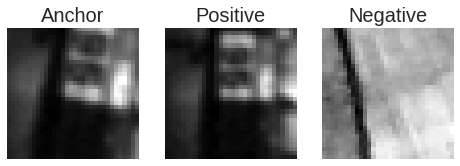

In [0]:
plot_triplet(training_generator)

We now train the descriptor model and save the weights afterward.

In [0]:
epochs = 1
### As with the denoising model, we use a loop to save for each epoch 
## #the weights in an external website in case colab stops. 
### reset, so e.g. calling 5 times fit(epochs=1) behave as fit(epochs=5)
### If you have a model saved from a previous training session
### Load it in the next line
#  descriptor_model_trip = keras.models.load_model('./descriptor.h5')
for e in range(epochs):
  descriptor_history = descriptor_model_trip.fit_generator(generator=training_generator, epochs=1, verbose=1, validation_data=val_generator)
  ### Saves optimizer and weights
  descriptor_model_trip.save('descriptor.h5') 
  ### Uploads files to external hosting
  !curl -F "file=@descriptor.h5" https://file.io
descriptor_model_trip.save_weights('descriptor.h5') 

NameError: ignored

In [0]:
Print network summary.

SyntaxError: ignored

In [0]:
descriptor_model_trip.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
a (InputLayer)                  (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
p (InputLayer)                  (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
n (InputLayer)                  (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 128)          1336928     a[0][0]                          
                                                                 p[0][0]                          
          

In [0]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.00001, min_delta = 0.01)

# Define the metric that will determine the earlyStopping
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 4)

descriptor_history = descriptor_model_trip.fit_generator(generator = training_generator,
                                                         epochs = 20,
                                                         verbose = 1,
                                                         #batch_size = 200,
                                                         validation_data = val_generator,
                                                         callbacks=[early_stopping]
                                                        )

In [0]:
print(descriptor_history.history.keys())

['acc', 'loss', 'val_acc', 'val_loss']


Text(0.5,0,'Epoch')

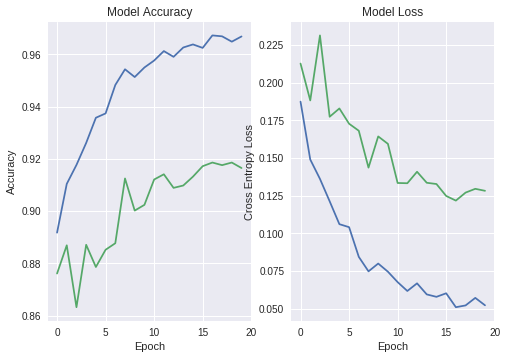

In [0]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,2)
axes[0].plot(descriptor_history.history['acc'])
axes[0].plot(descriptor_history.history['val_acc'])
axes[0].set_title('Model Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')

fig.subplots_adjust(hspace=0.5)

axes[1].plot(descriptor_history.history['loss'])
axes[1].plot(descriptor_history.history['val_loss'])
axes[1].set_title('Model Loss')
axes[1].set_ylabel('Cross Entropy Loss')
axes[1].set_xlabel('Epoch')

In [0]:
# Evaluate Loss
score = model.evaluate(X_test_flatten, Y_test_class, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# TensorBoard and optimisation attempt

In [0]:
!pip install tensorboardcolab
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
import tensorboardcolab as tbc
tboard = tbc.TensorBoardColab()
from tensorboardcolab import TensorBoardColabCallback

--2019-02-19 20:11:11--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.72.145.109, 52.72.250.2, 52.7.169.168, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.72.145.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]   5.11M  21.7MB/s    in 0.2s    

2019-02-19 20:11:11 (21.7 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Wait for 8 seconds...
TensorBoard link:
http://7d8be244.ngrok.io


In [0]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

# Define model
descriptor_model_trip_ae = Model(inputs=[xa, xp, xn], outputs=loss)
descriptor_model_trip_ae.compile(loss = 'mean_absolute_error',
                              optimizer= 'adam',
                              metrics=['accuracy','mean_squared_error'])
# Callback learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience = 2, min_lr=0.00001, min_delta = 0.01)

# Define the metric that will determine the earlyStopping
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 4)

descriptor_history_ae = descriptor_model_trip_ae.fit_generator(generator = training_generator,
                                                         epochs = 30,
                                                         verbose = 1,
                                                         #batch_size = 200,
                                                         validation_data = val_generator,
                                                         callbacks=[early_stopping,
                                                                    reduce_lr,
                                                                   TensorBoardColabCallback(tboard)]
                                                        )

# Evaluation section

## Generating descriptors files for test data 

To evaluate the performance of out model we will use an existing evaluation code, which is called HPatches benchmark. HPatches benchmark takes as input the descriptors for the test data in a CSV form. So the whole pipeline is represented in the following image.

![](https://i.ibb.co/WcDDf3q/Screenshot-from-2019-02-15-11-17-24.png)

This function generates those files by passing it a descriptor model and a denoising model. It performs a first step of denoising the patches, and a second one of computing the descriptor of the denoised patch. If no denoising model is given (variable set to `None`), the descriptor is computed directly in the noisy patch.

Similarly to the loading data part, you have the denoise_model variable and `use_clean` variable. If `use_clean` is set to True, the CSV generated will be those of the clean patches, even if a denoising model is given. If set to False, then depends on the variable `denoise_model`. If there is no denoise model (`denoise_model=None`), then it will use the noisy patches. If you give a denoising model, then it will compute the CSV for the denoised patches. This can be useful to explore different scenarios (for example, the Upper Bound can be training the descriptor network with clean patches, and testing with clean patches), however you should always report the score when using noisy patches (depending on the approach you develop, you may want to denoise them or not). The official baseline uses the denoised patches. 

In [0]:
generate_desc_csv(descriptor_model, seqs_test, denoise_model=denoise_model, use_clean=False)

100%|██████████| 40/40 [06:52<00:00, 10.26s/it]


## Evaluating descriptors in HPatches Benchmark
We use HPatches benchmark code to compute the results for our model. 

**Updated**: The necessary code is included in the repository we cloned at the beginning of the code, so we do not need to download any extra data. Also, we simplified the results, so now they only return one value for each of the three tasks.

Now we will perform the evaluation of three different tasks (Verification, Matching and Evaluation) using the CSV files we generated as input and the `hpatches_eval.py` script. We also print the results using the `hpatches_results.py` script. The scripts will return a score for each of the tasks. The metric used is called mean Average Precision, which it uses the Precision of the model. The Precision is defined, for a given number of retrieved elements, as the ratio of correct retrieved elements / number of retrieved elements. [Link to Wikipedia with Precision explanation](https://en.wikipedia.org/wiki/Precision_and_recall). The definition of the three different tasks is taken from the [HPatches paper](https://arxiv.org/pdf/1704.05939.pdf).

In all of the tasks if you use the optional argument `--more_info` in `hpatches_results.py` you can see extra mAP information. However, the important score is the mAP score reported without this flag.

### Verification

Patch verification measures the ability of a descriptor to classify whether two patches are extracted from the same measurement. Now we compute the score of our architecture in this task.




In [0]:
!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=verification --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=verification



>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating verification task
Processing verification task 1/3 : 100% 1000000/1000000 [01:27<00:00, 11410.09it/s]
Processing verification task 2/3 : 100% 1000000/1000000 [01:27<00:00, 11464.47it/s]
Processing verification task 3/3 : 100% 1000000/1000000 [01:28<00:00, 11353.62it/s]
>> Verification task finished in 271 secs  
Verification task results:
Mean Average Precision is 0.685319




### Matching
Image matching, tests to what extent a descriptor can correctly identify correspondences in two images.

In [0]:
!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=matching --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=matching



>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating matching task
100% 40/40 [02:12<00:00,  4.49s/it]
>> Matching task finished in 132 secs  
Matching task results:
Mean Average Precision is 0.091080






### Retrieval
Retrieval tests how well a descriptor can match a query patch to a pool of patches extracted from many images.

In [0]:
!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=retrieval --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=retrieval


>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating retrieval task
>> Please wait, computing distance matrix...
tcmalloc: large alloc 1600004096 bytes == 0x55e703f16000 @  0x7f78211d11e7 0x7f7816dd2cf1 0x7f7816e353a2 0x7f7816e370de 0x7f7816ece0e8 0x55e6ddc2cfe5 0x55e6ddc22d0a 0x55e6ddc2a5fe 0x55e6ddc2a232 0x55e6ddc22d0a 0x55e6ddc2ac38 0x55e6ddc22d0a 0x55e6ddc22629 0x55e6ddc5361f 0x55e6ddc4e322 0x55e6ddc4d67d 0x55e6ddbfc1ab 0x7f7820dceb97 0x55e6ddbfba2a
>> Distance matrix done.
Processing retrieval task: 100% 10000/10000 [03:55<00:00, 42.45it/s]
>> Retrieval task finished in 255 secs  
Retrieval task results:
Mean Average Precision is 0.335258




## Compressing and saving the CSV files 

This is not necessary for the analysis of the baseline code included in the report. However, we will be hosting a competition in an external website to see who can achieve the highest score. In that case, you will need to submit the CSV files, as the scoring script will be performed in an external server. With that aim, we include here a way to save the files either in your local disc or in your google drive account.

We first compress the directory with all the CSV by using the following command. Remove the `q` option if you want it to output the progress.

In [0]:
!zip -rq descriptors.zip ./out/custom

The generated .zip is quite large, the method we used for the weights does not work. We have two other methods. First, in the file explorer in the left column we can right-click in the file and then click download. Then, we will see a circle next to the file showing the download progress.

The second way does not require for you to download the files, it save the zip file in your Google Drive account, and you can download it later to your machine if you want. To do so, follow this method (found [here](https://stackoverflow.com/questions/49428332/how-to-download-large-files-like-weights-of-a-model-from-colaboratory)). First run the next cell, and the output will be a link for authentication purposes, and just follow the instructions

In [0]:
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

auth.authenticate_user()
drive_service = build('drive', 'v3')

def save_file_to_drive(name, path):
  file_metadata = {
    'name': name,
    'mimeType': 'application/octet-stream'
  }

  media = MediaFileUpload(path, 
                          mimetype='application/octet-stream',
                          resumable=True)

  created = drive_service.files().create(body=file_metadata,
                                  media_body=media,
                                  fields='id').execute()

  print('File ID: {}'.format(created.get('id')))

  return created


Now we can use the following function to save the file to your drive account. The second argument is the name of the file we want to save, and the first argument the name that will have in your Drive.

In [0]:
save_file_to_drive('descriptors_save.zip', 'descriptors.zip')

File ID: 1dHq0eDqoLMMmr6YOexZOU6cLwhFJYgH8


{u'id': u'1dHq0eDqoLMMmr6YOexZOU6cLwhFJYgH8'}